# 0. Install

In [1]:
!pip install torch torchvision tqdm ftfy regex
!pip install git+https://github.com/openai/CLIP.git
import sys
!{sys.executable} -m pip install git+https://github.com/openai/CLIP.git
!{sys.executable} -m pip install open-clip-torch
!{sys.executable} -m pip install addict orjson
!{sys.executable} -m pip install opencv-python-headless


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/openai/CLIP.git to /private/var/folders/30/gdtz3hy15130sl0mp2smt5fh0000gn/T/pip-req-build-hsnekumf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/30/gdtz3hy15130sl0mp2smt5fh0000gn/T/pip-req-build-hsnekumf
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import os
import torch
import clip
from tqdm import tqdm
from collections import OrderedDict
from types import SimpleNamespace
from addict import Dict 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
import math
import cv2
from PIL import Image
from torch import Tensor

In [7]:
from x_dual_encoders.models import wrapper
from x_dual_encoders.models.wrapper import XCLIP
from x_dual_encoders.evaluation.compute_attr import compute_attributions
from x_dual_encoders.models.tokenization import ClipTokenizer
from x_dual_encoders.utils.json_fns import load_json
from x_dual_encoders.evaluation.plotting import image_attribution_interpolation,plot_bbox,token_attr_to_tex
from datasets.hnc import HNCDataset

# Load Models

## Base model: ViT-B/32

In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [118]:
base_clip, base_preprocess = clip.load("ViT-B/32", device=device)

In [119]:
base_xclip = XCLIP(
    model=base_clip,
    image_dim=224,
    text_seq_len=77,
    text_ref_len=1,
    shift_embeddings=True,
    norm_embeddings=True,
    scale_cos=False,
    device=device,
    itm=False,
    img_ref_type='zeros'
).to(device)

## Fine tuned HNC_CLIP model

In [120]:
ft_clip, _ = clip.load("ViT-B/32", device=device)

In [121]:
ckpt_path = "/Users/wenwen/Desktop/xclip-main/w_models/HNC_KL_1_S_full_15.pt"
ckpt = torch.load(ckpt_path, map_location=device)
sd = {k.replace("module.",""):v for k,v in ckpt["state_dict"].items()}

In [122]:
ft_clip.load_state_dict(sd)
ft_clip.eval().to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [123]:
ft_xclip = XCLIP(
    model=ft_clip,
    image_dim=224,
    text_seq_len=77,
    text_ref_len=1,
    shift_embeddings=True,
    norm_embeddings=True,
    scale_cos=False,
    device=device,
    itm=False,
    img_ref_type='zeros'
).to(device)

# Tokenizer

In [124]:
tokenizer = ClipTokenizer()

# Load dataset

In [29]:
indices = list(range(3))

In [48]:
raw_cfg = {
    "datasets": {
        "hnc": {
            "images": "/Users/wenwen/Desktop/xclip-main/data/gqa_dataset/selected_images",
            "captions": {
                "train": "/Users/wenwen/Desktop/xclip-main/data/HNC/hnc_clean_strict_train.json",
                "valid": "/Users/wenwen/Desktop/xclip-main/data/HNC/hnc_clean_strict_valid.json",
                "test":  "/Users/wenwen/Desktop/xclip-main/data/HNC/hnc_clean_strict_test.json"
            }
        }
    },
    "training": {
        "dataset": "hnc",
        "only_correct_captions": False
    }
}
cfg = Dict(raw_cfg)

In [49]:
args = SimpleNamespace(
    debugging=False,
    train_data_ratio=1.0,
    create_ans_label_dicts=False,
    distributed=False,
    batch_size=1,
    inference_batch_size_scale=1,
    num_workers=4
)

In [52]:
hnc_ds = HNCDataset(
    args=args,
    cfg=cfg,
    split="test",
    ans2label="/Users/wenwen/Desktop/xclip-main/x_dual_encoders/meta_data/hnc_ans2label.json",
    label2ans="/Users/wenwen/Desktop/xclip-main/x_dual_encoders/meta_data/hnc_label2ans.json"
)

100%|██████████████████████████████████████| 101/101 [00:00<00:00, 37445.83it/s]


In [54]:
print(len(hnc_ds))

1884


In [55]:
class HNCWrapper(torch.utils.data.Dataset):
    def __init__(self, hnc_ds):
        self.h = hnc_ds
    def __len__(self):
        return len(self.h)
    def __getitem__(self, i):
        # HNCDataset return (caption, image, itm_label, textual_id, cpt_type, cpt_id, img_id)
        cpt, img, *_ , img_id = self.h[i]
        return {"image_id": img_id, "text": cpt, "image": img}

In [56]:
ds = HNCWrapper(hnc_ds)

# Sample

In [213]:
image_path = "/Users/wenwen/Desktop/xclip-main/data/gqa_dataset/selected_images/n16936.jpg"  
caption    = "The trees are behind the fence"  

In [214]:
sample = {
    "image_id": os.path.basename(image_path),
    "text":      caption,
    "image":     Image.open(image_path)
}

In [215]:
fake_ds = [ sample ]

In [216]:
indices = [0]
common_kwargs = dict(
    img_layer=11,
    txt_layer=11,
    N_steps=50,
    device=device,
    dst=None,        
    save_every=10,
    method='full'
)

# Evaluation

In [217]:
base_results = compute_attributions(
    model=base_xclip,
    img_prep=base_preprocess,
    tokenizer=tokenizer,
    ds=fake_ds,
    indices=indices,
    **common_kwargs
)

1it [01:19, 79.43s/it]


In [218]:
ft_results = compute_attributions(
    model=ft_xclip,
    img_prep=base_preprocess,
    tokenizer=tokenizer,
    ds=fake_ds,
    indices=indices,
    **common_kwargs
)

1it [01:20, 80.04s/it]


In [235]:
idx, A_base, score_base, *_, img_id = base_results[0]
idx2,A_ft,   score_ft,   *_, _      = ft_results[0]
sample = fake_ds[0]
img = sample["image"]
text = sample["text"]

print(f"Base CLIP score = {score_base:.3f}, Fine-tuned score = {score_ft:.3f}")
print("Base attribution shape:", A_base.shape)
print("Fine-tuned attribution shape:", A_ft.shape)

Base CLIP score = 0.043, Fine-tuned score = 0.167
Base attribution shape: torch.Size([8, 50])
Fine-tuned attribution shape: torch.Size([8, 50])


In [236]:
print(text)

The trees are behind the fence


In [237]:
token_ids = tokenizer.get_token_ids(text, append_sot_eot=True)
tokens = [tokenizer.decoder[i].replace("</w>", "") for i in token_ids]

In [238]:
G = int(math.sqrt(A_base.shape[1] - 1))
heat_base = A_base.sum(dim=0)[1:].reshape(G, G)
heat_ft   = A_ft.sum(dim=0)[1:].reshape(G, G)

In [239]:
overlay_base = image_attribution_interpolation(img, heat_base, alpha=0.6)

In [240]:
overlay_ft = image_attribution_interpolation(img, heat_ft, alpha=0.6)

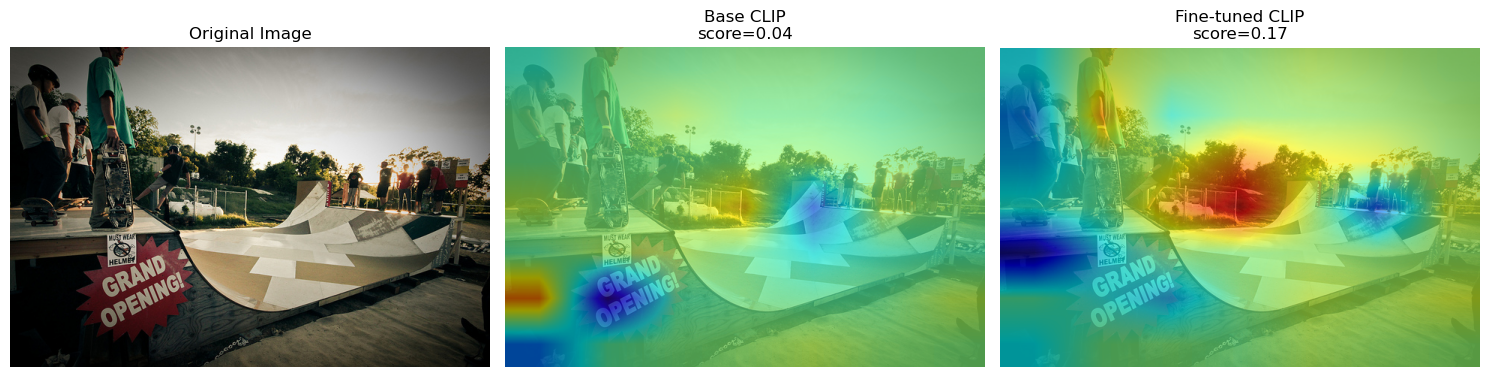

In [241]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, im, title in zip(
    axs,
    [img, overlay_base, overlay_ft],
    ["Original Image", f"Base CLIP\nscore={score_base:.2f}", f"Fine‐tuned CLIP\nscore={score_ft:.2f}"]
):
    ax.imshow(im)
    ax.axis("off")
    ax.set_title(title)
plt.tight_layout()
plt.show()

In [249]:
attr_base = A_base.sum(dim=1)
attr_ft   = A_ft.sum(dim=1)

tokens_core     = tokens[1:-1]
attr_base_core  = attr_base[1:-1]
attr_ft_core    = attr_ft[1:-1]

colored_base = token_attr_to_tex(attr_base_core, tokens_core)
colored_ft   = token_attr_to_tex(attr_ft_core,   tokens_core)

In [250]:
print("=== Base CLIP Token Attributions ===")
display(HTML(f"<div style='font-family:monospace; line-height:1.8'>{colored_base}</div>"))

print("\n=== Fine‐tuned CLIP Token Attributions ===")
display(HTML(f"<div style='font-family:monospace; line-height:1.8'>{colored_ft}</div>"))

=== Base CLIP Token Attributions ===



=== Fine‐tuned CLIP Token Attributions ===


In [254]:
h_norm_base = (attr_base_core.abs() / attr_base_core.abs().sum()).cpu().numpy()
h_norm_ft   = (attr_ft_core.abs()   / attr_ft_core.abs().sum()).cpu().numpy()

def render_spans_signed(tokens, h_norm, raw_attr):
    html = ""
    raw = raw_attr.cpu().numpy()
    for tok, intensity, val in zip(tokens, h_norm, raw):
        c = int(intensity * 255)
        if val >= 0:
            color = f"rgb(255,{255-c},{255-c})"
        else:
            color = f"rgb({255-c},{255-c},255)"
        html += (
            f'<span style="background-color: {color}; '
            f'padding:2px 4px; margin:1px; border-radius:4px;">{tok}</span> '
        )
    return html

html_base = render_spans_signed(tokens_core, h_norm_base, attr_base_core)
html_ft   = render_spans_signed(tokens_core, h_norm_ft,   attr_ft_core)

panel_html = f"""
<div style="font-family:monospace; line-height:1.6;">
  <div style="margin-bottom:20px;">
    <div style="font-weight:bold; margin-bottom:8px;">Base CLIP</div>
    <div>{html_base}</div>
  </div>
  <div>
    <div style="font-weight:bold; margin-bottom:8px;">Fine-tuned CLIP</div>
    <div>{html_ft}</div>
  </div>
</div>
"""
display(HTML(panel_html))



In [255]:
def overlay_token_attribution(
    image: Image,
    A: Tensor,
    tokens: list,
    token_str: str,
    alpha: float = 0.6,
    cmap=cv2.COLORMAP_JET
):
    i_txt = tokens.index(token_str)
    
    row = A[i_txt].cpu().numpy()          
    
    row = row[1:]
    G = int(math.sqrt(len(row)))           
    grid = row.reshape(G, G)
    
    hm = np.abs(grid)
    hm = hm / (hm.max() + 1e-8)
    
    H, W = image.size[1], image.size[0]

    heatmap = cv2.resize(
        (hm * 255).astype(np.uint8),
        (image.width, image.height),
        interpolation=cv2.INTER_LINEAR
    )
    color_hm = cv2.applyColorMap(heatmap, cmap)
    img_np = cv2.cvtColor(np.array(image.convert("RGB")), cv2.COLOR_RGB2BGR)
    over = cv2.addWeighted(img_np, 1 - alpha, color_hm, alpha, 0)
    over = cv2.cvtColor(over, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(6,6))
    plt.imshow(over)
    plt.axis("off")
    plt.title(f"Attribution for token '{token_str}'")
    plt.show()
    
    return over


Token = "the"
 Base CLIP:


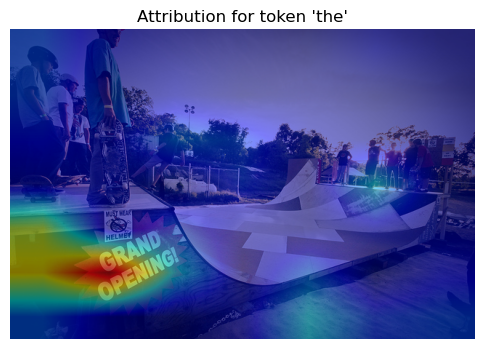

 Fine-tuned CLIP:


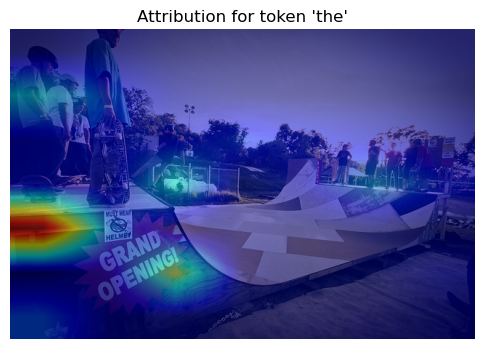


Token = "trees"
 Base CLIP:


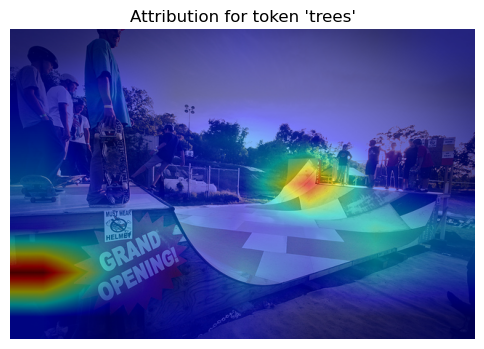

 Fine-tuned CLIP:


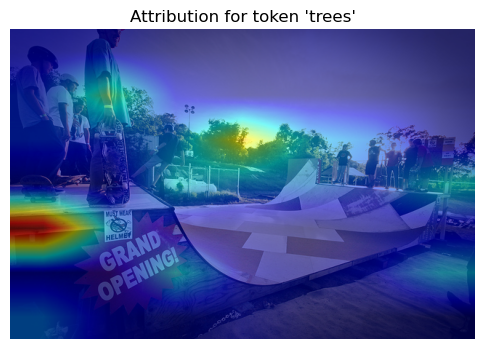


Token = "are"
 Base CLIP:


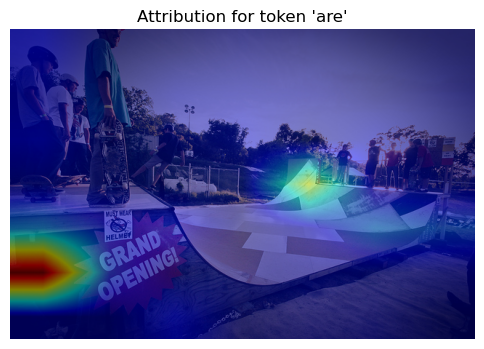

 Fine-tuned CLIP:


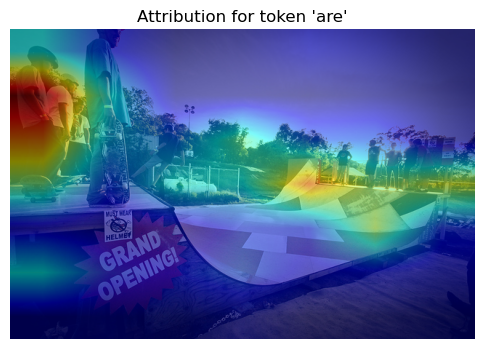


Token = "behind"
 Base CLIP:


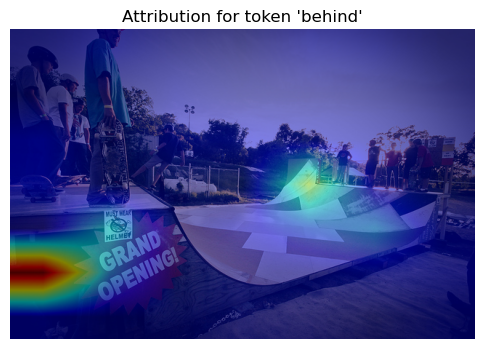

 Fine-tuned CLIP:


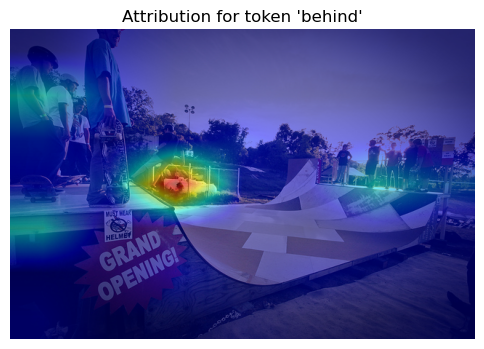


Token = "the"
 Base CLIP:


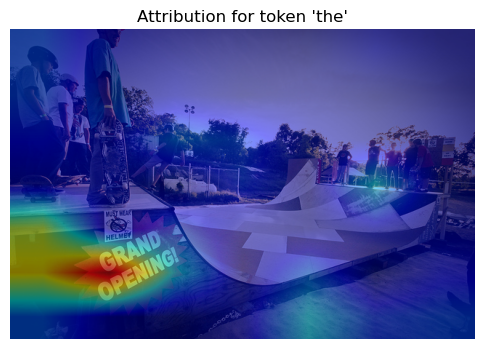

 Fine-tuned CLIP:


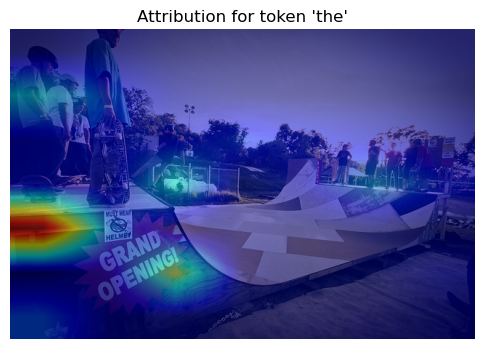


Token = "fence"
 Base CLIP:


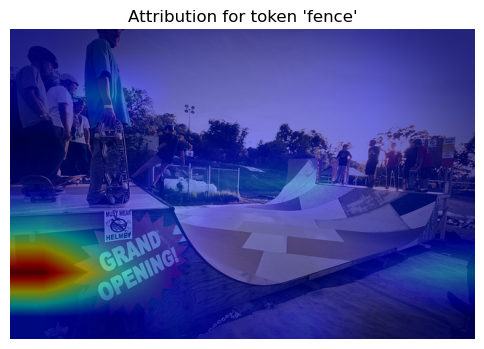

 Fine-tuned CLIP:


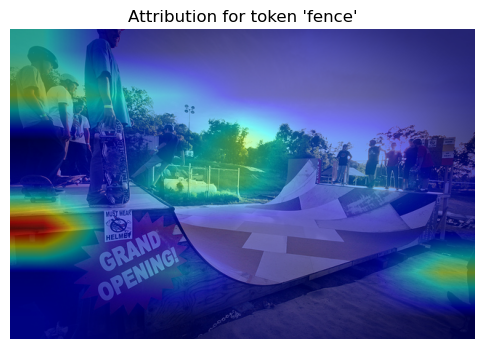

In [246]:
for tok in tokens[1:-1]:  
    print(f"\nToken = \"{tok}\"")
    print(" Base CLIP:")
    overlay_token_attribution(img, A_base, tokens, token_str=tok, alpha=0.5)
    print(" Fine-tuned CLIP:")
    overlay_token_attribution(img, A_ft,   tokens, token_str=tok, alpha=0.5)

In [247]:
def get_phrase_overlay(
    image,
    A,
    tokens,
    phrase,
    alpha=0.6,
    cmap=cv2.COLORMAP_JET
):
    words = phrase.split()
    idxs = []
    for w in words:
        matches = [i for i, t in enumerate(tokens) if t == w]
        if not matches:
            raise ValueError(f"Token '{w}' not in：{tokens}")
        idxs += matches
    combined = sum(A[i] for i in idxs).cpu().numpy()[1:]
    G = int(math.sqrt(len(combined)))
    grid = combined.reshape(G, G)
    hm = np.abs(grid)
    hm /= (hm.max() + 1e-8)
    W, H = image.size
    heatmap = cv2.resize((hm * 255).astype(np.uint8), (W, H),
                         interpolation=cv2.INTER_LINEAR)
    color_hm = cv2.applyColorMap(heatmap, cmap)
    img_np = cv2.cvtColor(np.array(image.convert("RGB")), cv2.COLOR_RGB2BGR)
    over = cv2.addWeighted(img_np, 1-alpha, color_hm, alpha, 0)
    over = cv2.cvtColor(over, cv2.COLOR_BGR2RGB)
    return over

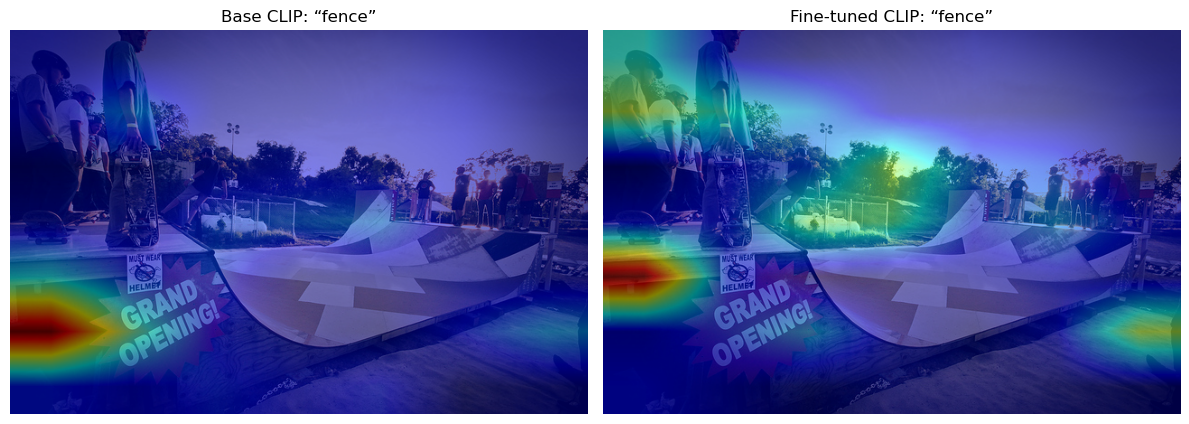

In [258]:
phrase = "fence"

overlay_base = get_phrase_overlay(img, A_base, tokens, phrase, alpha=0.5)
overlay_ft   = get_phrase_overlay(img, A_ft,   tokens, phrase, alpha=0.5)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, overlay, title in zip(
    axs,
    [overlay_base, overlay_ft],
    [f"Base CLIP: “{phrase}”", f"Fine-tuned CLIP: “{phrase}”"]
):
    ax.imshow(overlay)
    ax.axis("off")
    ax.set_title(title)
plt.tight_layout()
plt.show()